# A quick tutorial

This notebook provides a brief tutorial to modelling vehicle routing problems with PyVRP, introducing some of its most important modelling features:

- We first solve a capacitated VRP, introducing the modelling interface and the most basic components.
- We then solve a VRP with time windows, where we introduce the support PyVRP has for problems with duration constraints.
- We then solve a multi-depot VRP with time windows and maximum route duration constraints.
- We also solve a prize-collecting VRP with optional clients to showcase the modelling optional client visits.
- We finally solve a VRP with simultaneous pickup and delivery to show problems with deliveries from the depot to clients, and return shipments from clients to depots.

### Capacitated VRP

We will first model and solve the small capacitated VRP instance with 16 clients defined [in the OR-Tools documentation](https://developers.google.com/optimization/routing/cvrp).
This instance has an optimal solution of cost 6208.
The data are as follows:

In [1]:
# fmt: off
COORDS = [
    (456, 320),  # location 0 - the depot
    (228, 0),    # location 1
    (912, 0),    # location 2
    (0, 80),     # location 3
    (114, 80),   # location 4
    (570, 160),  # location 5
    (798, 160),  # location 6
    (342, 240),  # location 7
    (684, 240),  # location 8
    (570, 400),  # location 9
    (912, 400),  # location 10
    (114, 480),  # location 11
    (228, 480),  # location 12
    (342, 560),  # location 13
    (684, 560),  # location 14
    (0, 640),    # location 15
    (798, 640),  # location 16
]
DEMANDS = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]
# fmt: on

We can use the `pyvrp.Model` interface to conveniently specify our vehicle routing problem using this data.
A full description of the `Model` interface is given in our [API documentation](https://pyvrp.org/api/pyvrp.html#pyvrp.Model.Model).

In [2]:
from pyvrp import Model

m = Model()
m.add_vehicle_type(4, capacity=15)
depot = m.add_depot(x=COORDS[0][0], y=COORDS[0][1])
clients = [
    m.add_client(x=COORDS[idx][0], y=COORDS[idx][1], delivery=DEMANDS[idx])
    for idx in range(1, len(COORDS))
]

locations = [depot] + clients
for frm in locations:
    for to in locations:
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        m.add_edge(frm, to, distance=distance)

Let's inspect the resulting data instance.

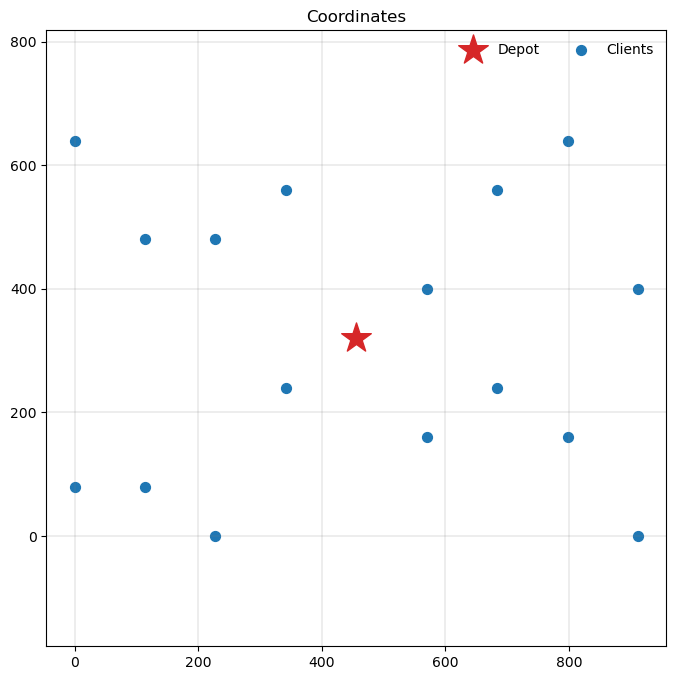

In [3]:
import matplotlib.pyplot as plt

from pyvrp.plotting import plot_coordinates

_, ax = plt.subplots(figsize=(8, 8))
plot_coordinates(m.data(), ax=ax)

The instance looks good, so we are ready to solve it.
Let's do so with a second of runtime, and display the search progress using the `display` argument on `Model.solve`.

In [4]:
from pyvrp.stop import MaxRuntime

res = m.solve(stop=MaxRuntime(1), display=True)  # one second

PyVRP v0.8.2

Solving an instance with:
    1 depot
    16 clients
    4 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      0s |  27     6208     6208 |  34     7134     6138
     1000      1s |  38     6208     6208 |  35     6806     5874
     1500      1s |  32     6221     6208 |  65     6442     5874

Search terminated in 1.00s after 1537 iterations.
Best-found solution has cost 6208.



By passing the `display` argument, PyVRP displays statistics about the solver progress and the instance being solved.
In particular, it outputs the sizes of the feasible and infeasible solution pools, their average objective values, and the objective of the best solutions in either pool.
A heuristic improvement is indicated by a `H` at the start of a line.

Let's print the solution we have found to see the routes.

In [5]:
print(res)

Solution results
    # routes: 4
   # clients: 16
   objective: 6208.00
# iterations: 1537
    run-time: 1.00 seconds

Routes
------
Route #1: 7 1 3 4 
Route #2: 5 6 2 8 
Route #3: 14 16 10 9 
Route #4: 13 15 11 12 



Good! Our solution attains the same objective value as the optimal solution OR-Tools finds.
Let's inspect our solution more closely.

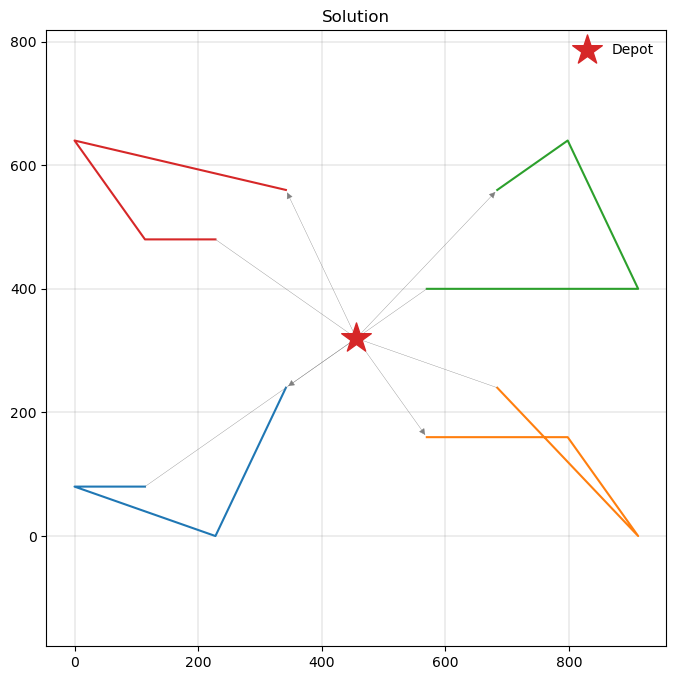

In [6]:
from pyvrp.plotting import plot_solution

_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, m.data(), ax=ax)

We have just solved our first vehicle routing problem using PyVRP!

.. warning::
   PyVRP automatically converts all numeric input values to integers.
   If your data has decimal values, you must scale and convert them to integers first to avoid unexpected behaviour.


### VRP with time windows


Besides the capacitated VRP, PyVRP also supports the VRP with time windows.
Let's see if we can also solve such an instance, again following the [OR-Tools documentation](https://developers.google.com/optimization/routing/vrptw).
Like in the OR-Tools example, we will ignore capacity restrictions, and give each vehicle a maximum route duration of 30.
Unlike the OR-Tools example, we still aim to minimise the total travel _distance_, not _duration_.

In [7]:
# fmt: off
DURATION_MATRIX = [
        [0, 6, 9, 8, 7, 3, 6, 2, 3, 2, 6, 6, 4, 4, 5, 9, 7],
        [6, 0, 8, 3, 2, 6, 8, 4, 8, 8, 13, 7, 5, 8, 12, 10, 14],
        [9, 8, 0, 11, 10, 6, 3, 9, 5, 8, 4, 15, 14, 13, 9, 18, 9],
        [8, 3, 11, 0, 1, 7, 10, 6, 10, 10, 14, 6, 7, 9, 14, 6, 16],
        [7, 2, 10, 1, 0, 6, 9, 4, 8, 9, 13, 4, 6, 8, 12, 8, 14],
        [3, 6, 6, 7, 6, 0, 2, 3, 2, 2, 7, 9, 7, 7, 6, 12, 8],
        [6, 8, 3, 10, 9, 2, 0, 6, 2, 5, 4, 12, 10, 10, 6, 15, 5],
        [2, 4, 9, 6, 4, 3, 6, 0, 4, 4, 8, 5, 4, 3, 7, 8, 10],
        [3, 8, 5, 10, 8, 2, 2, 4, 0, 3, 4, 9, 8, 7, 3, 13, 6],
        [2, 8, 8, 10, 9, 2, 5, 4, 3, 0, 4, 6, 5, 4, 3, 9, 5],
        [6, 13, 4, 14, 13, 7, 4, 8, 4, 4, 0, 10, 9, 8, 4, 13, 4],
        [6, 7, 15, 6, 4, 9, 12, 5, 9, 6, 10, 0, 1, 3, 7, 3, 10],
        [4, 5, 14, 7, 6, 7, 10, 4, 8, 5, 9, 1, 0, 2, 6, 4, 8],
        [4, 8, 13, 9, 8, 7, 10, 3, 7, 4, 8, 3, 2, 0, 4, 5, 6],
        [5, 12, 9, 14, 12, 6, 6, 7, 3, 3, 4, 7, 6, 4, 0, 9, 2],
        [9, 10, 18, 6, 8, 12, 15, 8, 13, 9, 13, 3, 4, 5, 9, 0, 9],
        [7, 14, 9, 16, 14, 8, 5, 10, 6, 5, 4, 10, 8, 6, 2, 9, 0],
]
TIME_WINDOWS = [
        (0, 999),  # location 0 - the depot (modified to be unrestricted)
        (7, 12),   # location 1
        (10, 15),  # location 2
        (16, 18),  # location 3
        (10, 13),  # location 4
        (0, 5),    # location 5
        (5, 10),   # location 6
        (0, 4),    # location 7
        (5, 10),   # location 8
        (0, 3),    # location 9
        (10, 16),  # location 10
        (10, 15),  # location 11
        (0, 5),    # location 12
        (5, 10),   # location 13
        (7, 8),    # location 14
        (10, 15),  # location 15
        (11, 15),  # location 16
]
# fmt: on

We now need to specify the time windows for all locations, and the duration of travelling along each edge.

In [8]:
m = Model()
m.add_vehicle_type(4, max_duration=30)
depot = m.add_depot(
    x=COORDS[0][0],
    y=COORDS[0][1],
    tw_early=TIME_WINDOWS[0][0],
    tw_late=TIME_WINDOWS[0][1],
)
clients = [
    m.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )
    for idx in range(1, len(COORDS))
]

locations = [depot] + clients
for frm_idx, frm in enumerate(locations):
    for to_idx, to in enumerate(locations):
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        duration = DURATION_MATRIX[frm_idx][to_idx]
        m.add_edge(frm, to, distance=distance, duration=duration)

In [9]:
res = m.solve(stop=MaxRuntime(1), display=False)  # one second
print(res)

Solution results
    # routes: 4
   # clients: 16
   objective: 6528.00
# iterations: 1053
    run-time: 1.00 seconds

Routes
------
Route #1: 9 14 16 
Route #2: 7 1 4 3 
Route #3: 12 13 15 11 
Route #4: 5 8 6 2 10 



Due to the hard time windows requirements, the total travel distance has increased slightly compared to our solution for the capacitated VRP.
Let's have a look at the new solution.

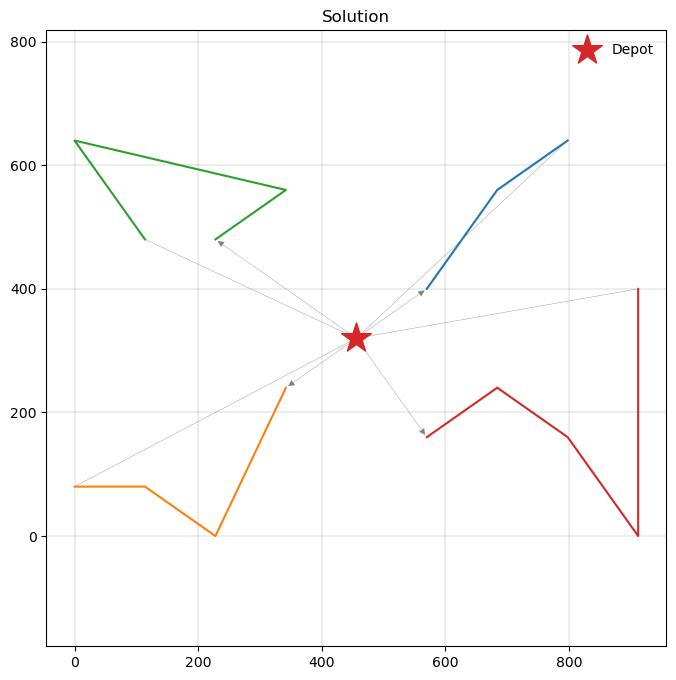

In [10]:
_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, m.data(), ax=ax)

### Multi-depot VRP with time windows

Let's now solve a VRP with multiple depots and time windows.
We consider two depots, and two vehicles per depot that have to start and end their routes at their respective depot.
For this, we will re-use some of the data from the VRPTW case, but change the time window data slightly: the first client now becomes the second depot.

In [11]:
# fmt: off
TIME_WINDOWS = [
    (0, 999),  # location 0 - a depot (modified to be unrestricted)
    (0, 999),  # location 1 - a depot (modified to be unrestricted)
    (10, 15),  # location 2
    (16, 18),  # location 3
    (10, 13),  # location 4
    (0, 5),    # location 5
    (5, 10),   # location 6
    (0, 4),    # location 7
    (5, 10),   # location 8
    (0, 3),    # location 9
    (10, 16),  # location 10
    (10, 15),  # location 11
    (0, 5),    # location 12
    (5, 10),   # location 13
    (7, 8),    # location 14
    (10, 15),  # location 15
    (11, 15),  # location 16
]
# fmt: on

In [12]:
m = Model()
depots = [
    m.add_depot(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )
    for idx in range(2)
]

for depot in depots:
    # Two vehicles at each of the depots, with maximum route durations
    # of 30.
    m.add_vehicle_type(2, depot=depot, max_duration=30)

clients = [
    m.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )
    for idx in range(2, len(COORDS))
]

locations = depots + clients
for frm_idx, frm in enumerate(locations):
    for to_idx, to in enumerate(locations):
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        duration = DURATION_MATRIX[frm_idx][to_idx]
        m.add_edge(frm, to, distance=distance, duration=duration)

Let's have a look at the modified data instance to familiarise ourself with the changes.

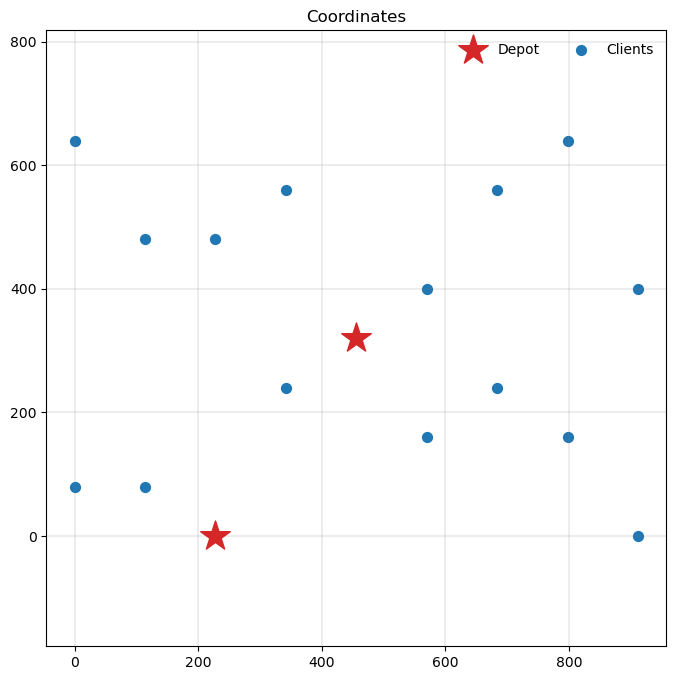

In [13]:
_, ax = plt.subplots(figsize=(8, 8))
plot_coordinates(m.data(), ax=ax)

Let's solve the instance.

In [14]:
res = m.solve(stop=MaxRuntime(1), display=False)  # one second
print(res)

Solution results
    # routes: 4
   # clients: 15
   objective: 6004.00
# iterations: 1344
    run-time: 1.00 seconds

Routes
------
Route #1: 7 5 8 6 2 10 
Route #2: 9 14 16 
Route #3: 12 13 15 11 
Route #4: 4 3 



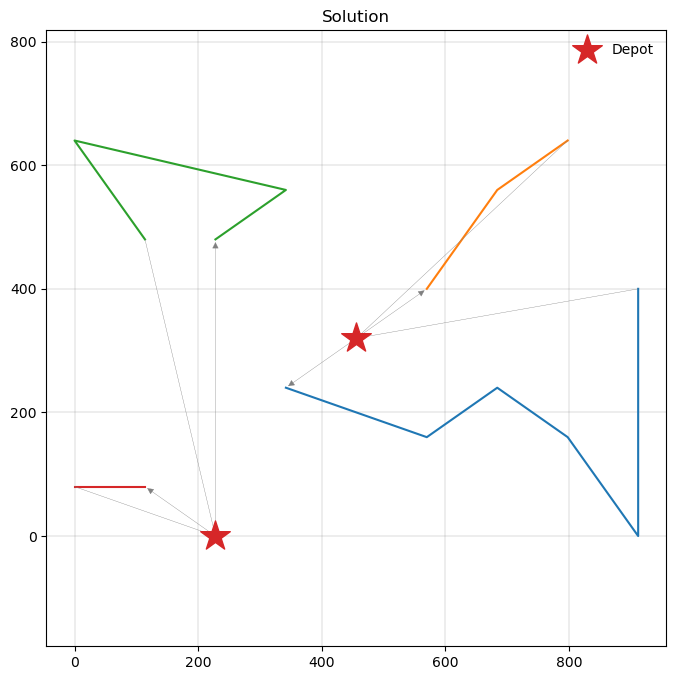

In [15]:
_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, m.data(), ax=ax)

### Prize-collecting VRP

We now have a basic familiarity with PyVRP's `Model` interface, but have not seen some of its additional features yet.
In this short section we will discuss _optional_ clients, which offer a reward (a prize) when they are visited, but are not required for feasibility.
This VRP variant is often called a prize-collecting VRP, and PyVRP supports this out-of-the-box.

Let's stick to the multiple depot setting, and also define a `PRIZES` list that provides the prizes of visiting each client.

In [16]:
# fmt: off
PRIZES = [
    0,    # location 0 - a depot
    0,    # location 1 - a depot
    334,  # location 2
    413,  # location 3
    295,  # location 4
    471,  # location 5
    399,  # location 6
    484,  # location 7
    369,  # location 8
    410,  # location 9
    471,  # location 10
    382,  # location 11
    347,  # location 12
    380,  # location 13
    409,  # location 14
    302,  # location 15
    411,  # location 16
]
# fmt: on

When modelling optional clients, it is important to provide both a reward (the `prize` argument to `add_client`), and to mark the client as optional by passing `required=False`:

In [17]:
m = Model()
depots = [
    m.add_depot(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )
    for idx in range(2)
]

for depot in depots:
    m.add_vehicle_type(2, depot=depot)

clients = [
    m.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
        prize=PRIZES[idx],
        required=False,
    )
    for idx in range(2, len(COORDS))
]

locations = depots + clients
for frm_idx, frm in enumerate(locations):
    for to_idx, to in enumerate(locations):
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        duration = DURATION_MATRIX[frm_idx][to_idx]
        m.add_edge(frm, to, distance=distance, duration=duration)

In [18]:
res = m.solve(stop=MaxRuntime(1), display=False)  # one second
print(res)

Solution results
    # routes: 3
   # clients: 10
   objective: 5145.00
# iterations: 1572
    run-time: 1.01 seconds

Routes
------
Route #1: 9 14 16 10 
Route #2: 7 5 6 8 
Route #3: 4 3 



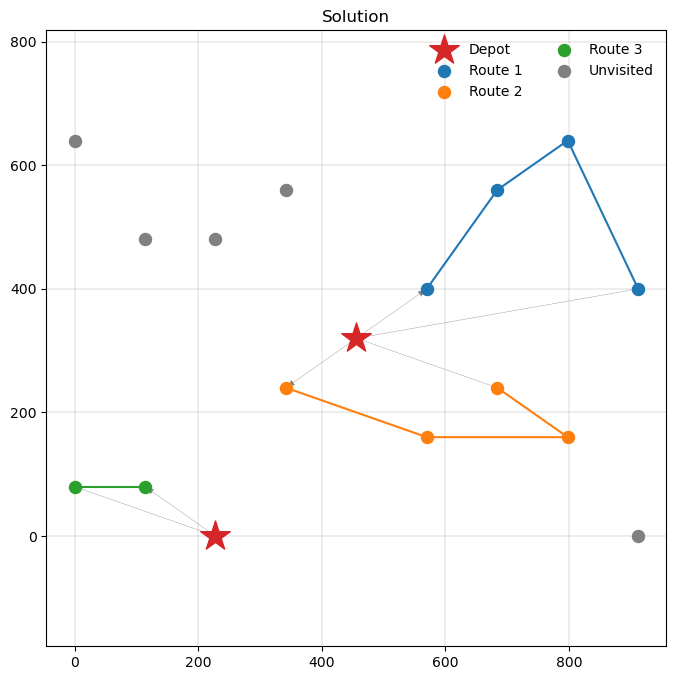

In [19]:
_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, m.data(), plot_clients=True, ax=ax)

Some clients are not visited in the figure above.
These clients are too far from other locations for their prizes to be worth the additional travel cost of visiting.
Thus, PyVRP's solver opts not to visit such optional clients.

### VRP with simultaneous pickup and delivery

Finally, we consider the VRP with simultaneous pickup and delivery.
In this problem variant, clients request items from the depot, and also produce return shipments that needs to be delivered back to the depot after visiting the client.
Thus, there are both deliveries from the depot to the clients, and pickups from the clients to the depot.

Let's remain in the multi-depot, prize-collecting world we entered through the last example.
We first define a `LOADS` list that tracks the delivery and pickup amount for each location:

In [20]:
# fmt: off
LOADS = [
    (0, 0),   # location 0 - a depot
    (0, 0),   # location 1 - a depot
    (1, 4),   # location 2 - simultaneous pickup and delivery
    (2, 0),   # location 3 - pure delivery
    (0, 5),   # location 4 - pure pickup
    (6, 3),   # location 5 - simultaneous pickup and delivery
    (4, 7),   # location 6 - simultaneous pickup and delivery
    (11, 0),  # location 7 - pure delivery
    (3, 0),   # location 8 - pure delivery
    (0, 5),   # location 9 - pure pickup
    (6, 4),   # location 10 - simultaneous pickup and delivery
    (1, 4),   # location 11 - simultaneous pickup and delivery
    (0, 3),   # location 12 - pure pickup
    (6, 0),   # location 13 - pure delivery
    (3, 2),   # location 14 - simultaneous pickup and delivery
    (4, 3),   # location 15 - simultaneous pickup and delivery
    (0, 6),   # location 16 - pure pickup
]
# fmt: on

In [21]:
m = Model()
depots = [
    m.add_depot(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )
    for idx in range(2)
]

for depot in depots:
    m.add_vehicle_type(2, depot=depot, capacity=15)

clients = [
    m.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
        delivery=LOADS[idx][0],
        pickup=LOADS[idx][1],
        prize=PRIZES[idx],
        required=False,
    )
    for idx in range(2, len(COORDS))
]

locations = depots + clients
for frm_idx, frm in enumerate(locations):
    for to_idx, to in enumerate(locations):
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        duration = DURATION_MATRIX[frm_idx][to_idx]
        m.add_edge(frm, to, distance=distance, duration=duration)

In [22]:
res = m.solve(stop=MaxRuntime(1), display=False)  # one second
print(res)

Solution results
    # routes: 3
   # clients: 6
   objective: 5375.00
# iterations: 1536
    run-time: 1.00 seconds

Routes
------
Route #1: 7 
Route #2: 9 5 8 
Route #3: 4 3 



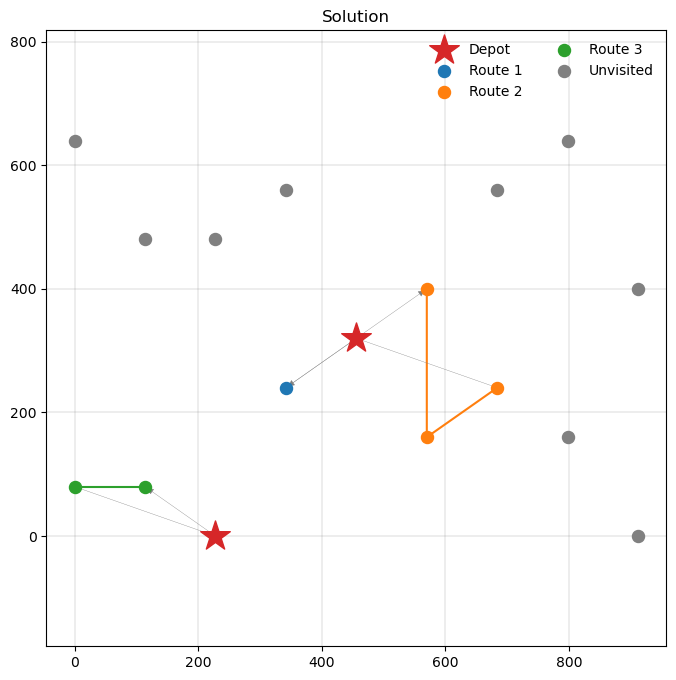

In [23]:
_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, m.data(), plot_clients=True, ax=ax)

This concludes the brief tutorial: you now know how to model and solve vehicle routing problems using PyVRP's `Model` interface.
PyVRP supports several additional VRP variants we have not covered here.
Have a look at the VRP introduction and other documentation pages to see how those can be modelled and solved. 